Will compare the three best models, pick the best one, check it, and then analyze how it relates to various covariates.

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import json
import hmmlearn

# load the original obs the models were tested on

In [3]:
# Combine all subjects
print("Loading data...")
with open("../cleaned_data_files/subject_data_for_HMM.json", "r") as f:
    subject_data = json.load(f)
print(f"Loaded {len(subject_data)} subjects")

test_subjects = list(subject_data.keys())#all subjects

all_obs = []
lengths = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    obs = np.column_stack([accuracy, rest_duration])
    all_obs.append(obs)
    lengths.append(len(obs))
pooled_obs = np.vstack(all_obs)
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")
pooled_obs[:, 1] = pooled_obs[:, 1] / 20  # Scale rest to 0-1 range
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")

Loading data...
Loaded 84 subjects
Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


# selecting best model

In [4]:
# Load all models
models_dir = 'pooled_models'
models_data = {}
model_files = {
    '2-state': 'max2s_complete_best_pooled_hmm_analysis.pkl',
    '3-state': 'max3s_complete_best_pooled_hmm_analysis.pkl',
    '4-state': 'max4s_complete_best_pooled_hmm_analysis.pkl', 
    '5-state': 'max5s_complete_best_pooled_hmm_analysis.pkl',
    '6-state': 'max6s_complete_best_pooled_hmm_analysis.pkl'
}

print("Loading saved models...")
for name, filename in model_files.items():
    full_file = f"{models_dir}/{filename}"
    try:
        with open(full_file, 'rb') as f:
            models_data[name] = pickle.load(f)
        print(f"Loaded {name} model")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

if not models_data:
    print("No models loaded successfully!")
    
# Extract key information
comparison_results = {}

Loading saved models...
Loaded 2-state model
Loaded 3-state model
Loaded 4-state model
Loaded 5-state model
Loaded 6-state model


In [5]:
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

for name, data in models_data.items():
    model = data['model']
    
    # Basic info
    n_states = model.n_components
    score = data.get('score', data.get('performance', {}).get('log_likelihood', 'Unknown'))
    converged = model.monitor_.converged
    
    # Calculate parameters (for AIC/BIC)
    n_params = (n_states * n_states +          # transition matrix
               n_states * 2 * 2 +             # emission means (2 features)
               n_states * 3 +                 # covariance params (full)
               n_states - 1)                  # initial probs (n-1 free params)
    
    comparison_results[name] = {
        'n_states': n_states,
        'log_likelihood': score,
        'converged': converged,
        'n_params': n_params,
        'model': model,
        'data_context': data.get('data_context', {}),
        'means': model.means_,
        'transitions': model.transmat_
    }
    
    # Calculate AIC and BIC
    if isinstance(score, (int, float)):
        aic = -2 * score + 2 * n_params
        bic = -2 * score + np.log(2520) * n_params  # Assuming ~2520 observations
        comparison_results[name]['aic'] = aic
        comparison_results[name]['bic'] = bic
    
    print(f"\n{name.upper()} MODEL:")
    print(f"  States: {n_states}")
    print(f"  Log-likelihood: {score}")
    print(f"  Converged: {converged}")
    print(f"  Parameters: {n_params}")
    if isinstance(score, (int, float)):
        print(f"  AIC: {aic:.2f}")
        print(f"  BIC: {bic:.2f}")


MODEL COMPARISON SUMMARY

2-STATE MODEL:
  States: 2
  Log-likelihood: 1629.4924888615164
  Converged: True
  Parameters: 19
  AIC: -3220.98
  BIC: -3110.18

3-STATE MODEL:
  States: 3
  Log-likelihood: 3357.698192540759
  Converged: True
  Parameters: 32
  AIC: -6651.40
  BIC: -6464.77

4-STATE MODEL:
  States: 4
  Log-likelihood: 5323.097546658377
  Converged: True
  Parameters: 47
  AIC: -10552.20
  BIC: -10278.09

5-STATE MODEL:
  States: 5
  Log-likelihood: 5798.579243746978
  Converged: True
  Parameters: 64
  AIC: -11469.16
  BIC: -11095.91

6-STATE MODEL:
  States: 6
  Log-likelihood: 6335.37871724057
  Converged: True
  Parameters: 83
  AIC: -12504.76
  BIC: -12020.70


In [6]:
# Model selection based on information criteria
print("\n" + "="*50)
print("MODEL SELECTION CRITERIA")
print("="*50)

# Find best model by different criteria
valid_models = {name: data for name, data in comparison_results.items() 
               if isinstance(data['log_likelihood'], (int, float))}

if valid_models:
    best_ll = max(valid_models.keys(), key=lambda x: valid_models[x]['log_likelihood'])
    best_aic = min(valid_models.keys(), key=lambda x: valid_models[x]['aic'])
    best_bic = min(valid_models.keys(), key=lambda x: valid_models[x]['bic'])
    
    print(f"Best by Log-Likelihood: {best_ll}")
    print(f"Best by AIC (complexity penalty): {best_aic}")
    print(f"Best by BIC (stronger penalty): {best_bic}")
    
    # Check if they agree
    if best_aic == best_bic:
        print(f"\n {best_aic} model is best by both AIC and BIC")
    else:
        print(f"\n AIC favors {best_aic}, BIC favors {best_bic}")


MODEL SELECTION CRITERIA
Best by Log-Likelihood: 6-state
Best by AIC (complexity penalty): 6-state
Best by BIC (stronger penalty): 6-state

 6-state model is best by both AIC and BIC


In [7]:
# Detailed state analysis
print("\n" + "="*50)
print("STATE CHARACTERISTICS COMPARISON")
print("="*50)

for name, data in comparison_results.items():
    model = data['model']
    n_states = data['n_states']
    
    print(f"\n{name.upper()} - STATE MEANS:")
    
    # Convert rest back to original scale (assuming /20 scaling)
    scaling_factor = data.get('data_context', {}).get('scaling_factor', 20)
    
    # Sort states by rest duration for consistent comparison
    rest_means = model.means_[:, 1] * scaling_factor
    state_order = np.argsort(rest_means)
    
    for idx, state_idx in enumerate(state_order):
        acc = model.means_[state_idx, 0]
        rest = rest_means[state_idx]
        
        # Assign interpretable names
        if n_states == 3:
            state_names = ["FOCUSED", "INTERMEDIATE", "FATIGUE"]
        elif n_states == 4:
            state_names = ["FOCUSED", "MILD-FATIGUE", "MODERATE-FATIGUE", "SEVERE-FATIGUE"]
        elif n_states == 5:
            state_names = ["FOCUSED", "LIGHT-FATIGUE", "MILD-FATIGUE", "MODERATE-FATIGUE", "SEVERE-FATIGUE"]
        else:
            state_names = [f"STATE-{i+1}" for i in range(n_states)]
        
        state_name = state_names[idx] if idx < len(state_names) else f"STATE-{idx+1}"
        print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")

# State usage analysis
print("\n" + "="*70)
print("STATE USAGE ANALYSIS")
print("="*70)

#show transition patterns
for name, data in comparison_results.items():
    model = data['model']
    print(f"\n{name.upper()} - TRANSITION PERSISTENCE:")
    
    diagonal_values = np.diag(model.transmat_)
    for i, persistence in enumerate(diagonal_values):
        print(f"  State {i}: {persistence:.3f} ({persistence*100:.1f}% stay)")
    
    # Check for reasonable persistence
    reasonable_states = np.sum((diagonal_values > 0.3) & (diagonal_values < 0.99))
    print(f"  States with reasonable persistence: {reasonable_states}/{len(diagonal_values)}")


STATE CHARACTERISTICS COMPARISON

2-STATE - STATE MEANS:
  STATE-1: accuracy=0.770, rest=4.3 trials
  STATE-2: accuracy=0.657, rest=20.0 trials

3-STATE - STATE MEANS:
  FOCUSED: accuracy=0.913, rest=1.2 trials
  INTERMEDIATE: accuracy=0.670, rest=6.4 trials
  FATIGUE: accuracy=0.657, rest=20.0 trials

4-STATE - STATE MEANS:
  FOCUSED: accuracy=0.901, rest=1.0 trials
  MILD-FATIGUE: accuracy=0.816, rest=6.2 trials
  MODERATE-FATIGUE: accuracy=0.000, rest=6.7 trials
  SEVERE-FATIGUE: accuracy=0.682, rest=20.0 trials

5-STATE - STATE MEANS:
  FOCUSED: accuracy=0.901, rest=1.0 trials
  LIGHT-FATIGUE: accuracy=0.922, rest=4.5 trials
  MILD-FATIGUE: accuracy=0.687, rest=8.2 trials
  MODERATE-FATIGUE: accuracy=0.000, rest=8.8 trials
  SEVERE-FATIGUE: accuracy=0.728, rest=20.0 trials

6-STATE - STATE MEANS:
  STATE-1: accuracy=0.896, rest=1.0 trials
  STATE-2: accuracy=0.005, rest=5.4 trials
  STATE-3: accuracy=0.629, rest=5.8 trials
  STATE-4: accuracy=0.875, rest=6.4 trials
  STATE-5: accu

In [ ]:
# check how often 4,5,and 6 use the 0 accuracy states
predicted_states = models_data['4-state']['model'].predict(pooled_obs, lengths=lengths)
state_counts = np.bincount(predicted_states, minlength=2)
for i, count in enumerate(state_counts):
    print(f"State {i}: {count} observations ({count/len(predicted_states)*100:.1f}%)")

print(f"Minimum accuracy in data: {pooled_obs[:, 0].min()}")
print(f"Observations with accuracy < 0.1: {np.sum(pooled_obs[:, 0] < 0.1)}")

*Analyis: **5-state model** seems like its the best mathematically + is still interpretable, but **3-state model** seems like it has the best interpretability. 6-state model doesnt use all the states as equally and is also less interpretable.* 

# 3-State model

In [11]:
curr_model = models_data['3-state']['model']

In [13]:
rest_means = curr_model.means_[:, 1] * scaling_factor
state_order = np.argsort(rest_means)

for idx, state_idx in enumerate(state_order):
    acc = curr_model.means_[state_idx, 0]
    rest = rest_means[state_idx]
    
    state_name = state_names[idx] if idx < len(state_names) else f"STATE-{idx+1}"
    print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")


  STATE-1: accuracy=0.913, rest=1.2 trials
  STATE-2: accuracy=0.670, rest=6.4 trials
  STATE-3: accuracy=0.657, rest=20.0 trials


Load the model and predict per subject

In [8]:

subject_state_sequences = {}
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
    obs = np.column_stack([accuracy, rest_duration])
    state_seq = curr_model.predict(obs)
    subject_state_sequences[subject_id] = state_seq

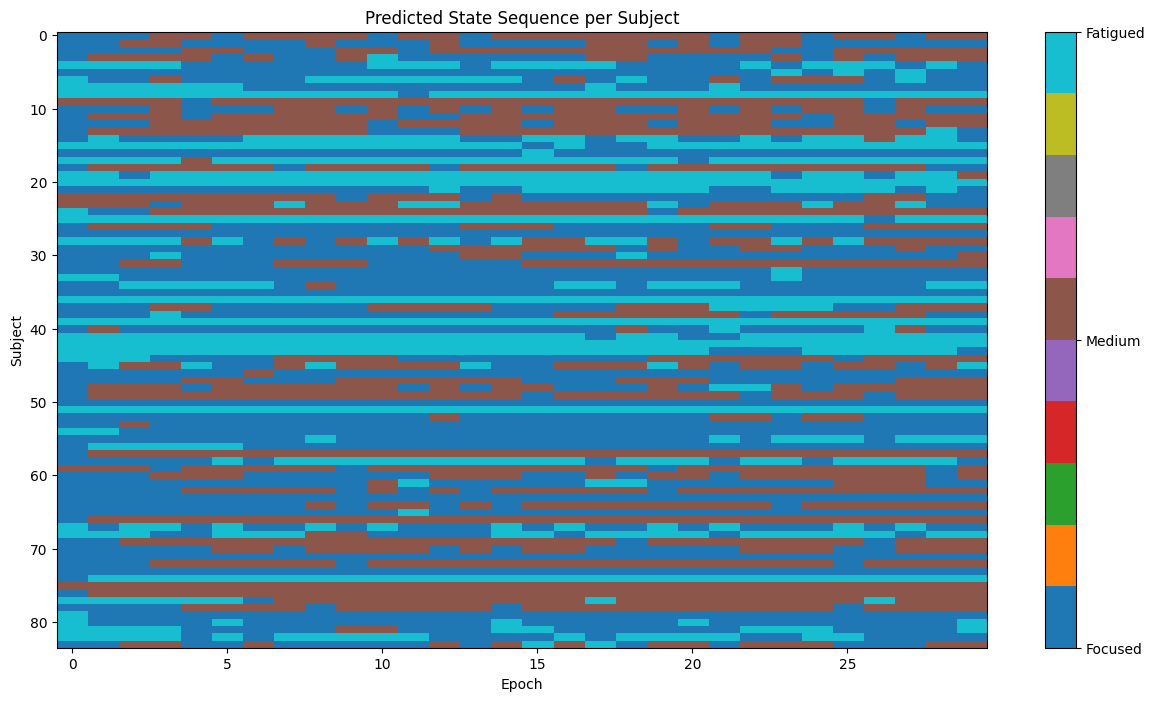

In [41]:
# Build a matrix: rows=subjects, cols=epochs, values=state
n_subjects = len(test_subjects)
n_epochs = len(next(iter(subject_state_sequences.values())))
state_matrix = np.zeros((n_subjects, n_epochs), dtype=int)

for i, subject_id in enumerate(test_subjects):
    state_matrix[i, :] = subject_state_sequences[subject_id]

plt.figure(figsize=(15, 8))
im = plt.imshow(state_matrix, aspect='auto', cmap='tab10', vmin=0, vmax=2)
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Focused', 'Medium', 'Fatigued'])  # or your own labels
plt.xlabel('Epoch')
plt.ylabel('Subject')
plt.title('Predicted State Sequence per Subject')
plt.show()

recovery
 0    1897
-1     280
 1     259
Name: count, dtype: int64
           count       mean       std  min   25%  50%   75%   max
recovery                                                         
-1         280.0   6.282143  5.029914  1.0  2.75  5.0   9.0  19.0
 0        1897.0   8.046916  7.660547  1.0  1.00  5.0  18.0  20.0
 1         259.0  10.281853  9.408973  1.0  1.00  2.0  20.0  20.0


/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_84950/1515870100.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = rest_recovery_df.groupby('recovery_cat')['rest'].mean()


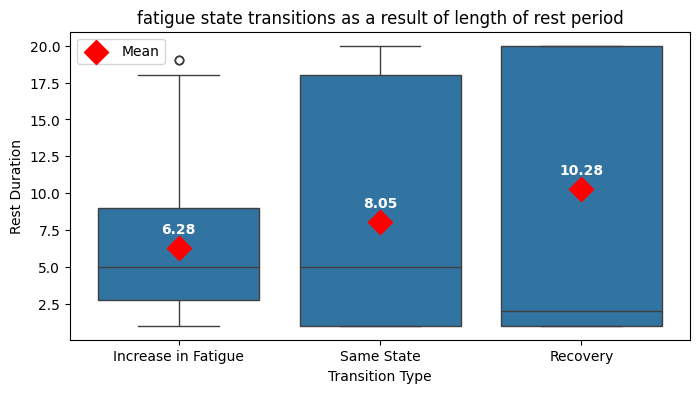

In [39]:
# (least to most fatigued)
fatigue_order = [0, 1, 2]

# collect rest durations and transitions
rest_recovery = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    rest = np.array(subj['post_epoch_post_cue_rest_duration'])
    state_seq = subject_state_sequences[subject_id]
    for t in range(len(rest) - 1):
        from_state = state_seq[t]
        to_state = state_seq[t + 1]
        rest_now = rest[t]

        if fatigue_order.index(to_state) < fatigue_order.index(from_state):
            recovery = 1  # transition to less fatigue (recovery)
        elif fatigue_order.index(to_state) > fatigue_order.index(from_state):
            recovery = -1 # transition to more fatigue
        else:
            recovery = 0  # same fatigue
        rest_recovery.append({'rest': rest_now, 'recovery': recovery})

rest_recovery_df = pd.DataFrame(rest_recovery)

# print info on the df
print(rest_recovery_df['recovery'].value_counts())
print(rest_recovery_df.groupby('recovery')['rest'].describe())

# plot the recoery states as a block plot
plt.figure(figsize=(8, 4))
cat_order = [-1, 0, 1]
cat_labels = ['Increase in Fatigue', 'Same State', 'Recovery']
rest_recovery_df['recovery_cat'] = pd.Categorical(rest_recovery_df['recovery'], categories=cat_order, ordered=True)
ax = sns.boxplot(x='recovery_cat', y='rest', data=rest_recovery_df, order=cat_order)
means = rest_recovery_df.groupby('recovery_cat')['rest'].mean()
# Plot means
for i, mean in enumerate(means):
    plt.scatter(i, mean, color='red', marker='D', s=150, zorder=10, label='Mean' if i == 0 else "")
    plt.text(i, mean + 1, f"{mean:.2f}", color='white', ha='center', fontweight='bold', zorder=11)
plt.xticks([0, 1, 2], cat_labels)
plt.title('fatigue state transitions as a result of length of rest period')
plt.xlabel('Transition Type')
plt.ylabel('Rest Duration')
plt.legend()
plt.show()